In [1]:
from joblib import load
import pandas
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import seaborn
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy

# Load grid results

In [430]:
analysis = pandas.concat([
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run1/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_classes/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_classes_2/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_classes_3/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_remaining/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_remaining_2/analysis.dat"),
    load("/home/maximl/scratch/results/reliability/alpha_data_generator/grid_run_remaining_3/analysis.dat")
])

In [416]:
analysis = pandas.concat([
    load("/home/maximl/scratch/results/reliability/sphere_generator/grid_run_newdatagenerator/analysis.dat"),
])

In [2]:
analysis = pandas.concat([
    load("/home/maximl/Data/Experiment_data/results/riverrel/artificial_data/899c1651a0155fcfd0bfb86b16607dde3ac19e49/analysis.dat"),
])

In [395]:
analysis.to_pickle("/home/maximl/scratch/results/reliability/all_06052020_0855.dat", protocol=4)

In [417]:
analysis.to_pickle("/home/maximl/scratch/results/reliability/all_11052020_0912.dat", protocol=4)

In [3]:
analysis["peace_cat"] = analysis["peace"].map(lambda a: {-1: "worse", 0: "same", 1: "better"}[a])

In [4]:
analysis["cw_peace_pace"] = analysis["class_wise_peace"].map(lambda a: {-1: "worse", 0: "same", 1: "better"}[a])

In [5]:
analysis["clf_enc"] = OrdinalEncoder().fit_transform(analysis["clf"].values.reshape(-1, 1))

# Inspect grid

In [439]:
grid_alpha = {
    "features": [2, 5, 10, 30, 50],
    "alpha": [0.1, 0.3, 0.5, 0.7, 1.0],
    "centers": [3, 5, 8],
    "classes": [2, 5, 10, 20, 50, 70]
}

In [435]:
grid_sphere = {
    "features": [10, 30, 50],
    "imbalance": [0.1, 0.5, 1.0, 1.5, 2, 5, 10],
    "std": [0.5, 1, 1.5, 2],
    "radius": [.1, .5, 1, 2, 4],
    "classes": [2, 5, 10, 20, 50, 70]
}

In [440]:
grid = grid_alpha

In [6]:
grid = {
        "features": [10, 30],
        "imbalance": [0.1, 1.0, 1.5, 5],
        "std": [0.5, 1, 1.5, 2],
        "radius": [.5, 1, 2, 4],
        "classes": [2, 5, 10]
}

In [7]:
f = list(grid.keys())
parameter_grid = pandas.DataFrame([instance for instance in ParameterGrid(grid)])
parameter_grid["results?"] = parameter_grid.apply(lambda a: (analysis[a.index] == a).all(axis=1).any(), axis=1)
parameter_grid["count"] = parameter_grid[f].apply(lambda a: (analysis[a.index] == a).all(axis=1).sum(), axis=1)

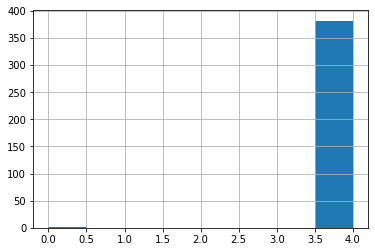

In [8]:
parameter_grid["count"].hist(bins=8)

In [9]:
parameter_grid["count"].value_counts()

4    382
0      2
Name: count, dtype: int64

In [10]:
parameter_grid["results?"].value_counts()

True     382
False      2
Name: results?, dtype: int64

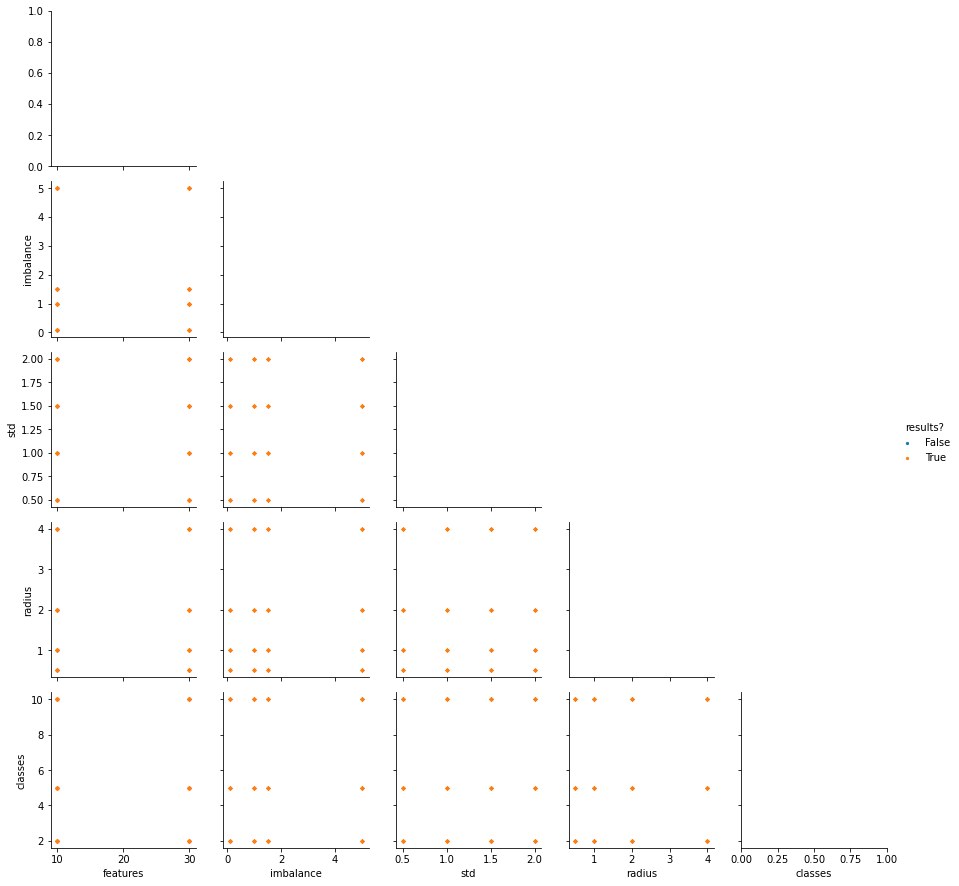

In [11]:
g = seaborn.PairGrid(parameter_grid[f + ["results?"]], hue="results?", corner=True)
g.map_offdiag(plt.scatter, s=5, marker="o")
g.add_legend()

In [12]:
import hiplot
data = parameter_grid[list(grid.keys())+["results?"]].to_dict('records')
hiplot.Experiment().from_iterable(data).display()

<IPython.core.display.Javascript object>

# Inspect results

In [34]:
analysis.head()

,n_processes,task_id,n_tasks,output_dir,analysis,remove,dummy,debug,classes,features,...,filename,clf,class_wise_ece,class_wise_ece_balanced,class_wise_peace,ece_balanced,peace,peace_cat,cw_peace_pace,clf_enc
0,9,1,15,/user/gent/420/vsc42015/vsc_data_vo/results/re...,None,False,False,False,2,10,...,0.dat,Gaussian Naive Bayes,0,1,1,1,1,better,better,0.0
0,9,1,15,/user/gent/420/vsc42015/vsc_data_vo/results/re...,None,False,False,False,2,10,...,0.dat,Linear SVM,0,1,1,1,1,better,better,1.0
0,9,1,15,/user/gent/420/vsc42015/vsc_data_vo/results/re...,None,False,False,False,2,10,...,0.dat,Random Forest,0,1,1,1,1,better,better,3.0
0,9,1,15,/user/gent/420/vsc42015/vsc_data_vo/results/re...,None,False,False,False,2,10,...,0.dat,Logistic Regression,0,1,1,1,1,better,better,2.0
1,9,1,15,/user/gent/420/vsc42015/vsc_data_vo/results/re...,None,False,False,False,2,10,...,1.dat,Gaussian Naive Bayes,0,1,1,1,1,better,better,0.0


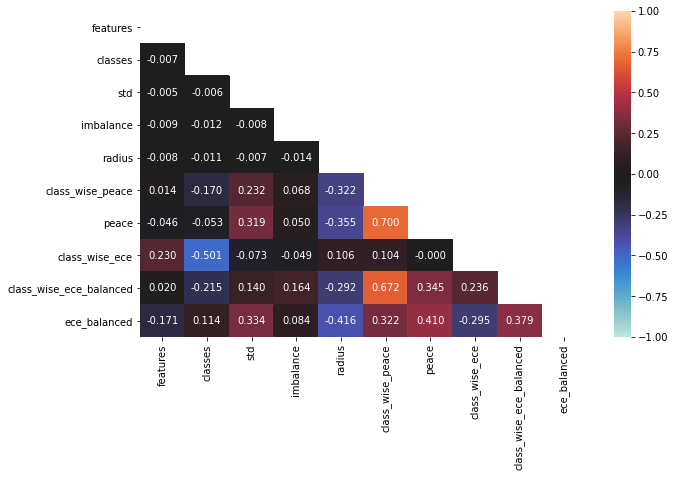

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

corr = analysis[["features", "classes", "std", 'imbalance', "radius", "class_wise_peace", "peace", "class_wise_ece", "class_wise_ece_balanced", "ece_balanced", "clf"]].corr()
mask = numpy.zeros_like(corr)
mask[numpy.triu_indices_from(mask)] = True
seaborn.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, center=0, fmt=".3f", ax=ax)

In [33]:
for idx, grouped_df in df.groupby("std"):
    print(idx)
    print(grouped_df["class_wise_peace"].value_counts())

0.5
-1    64
 1    32
Name: class_wise_peace, dtype: int64
1.0
-1    52
 1    44
Name: class_wise_peace, dtype: int64
1.5
-1    49
 1    46
Name: class_wise_peace, dtype: int64
2.0
 1    53
-1    42
Name: class_wise_peace, dtype: int64


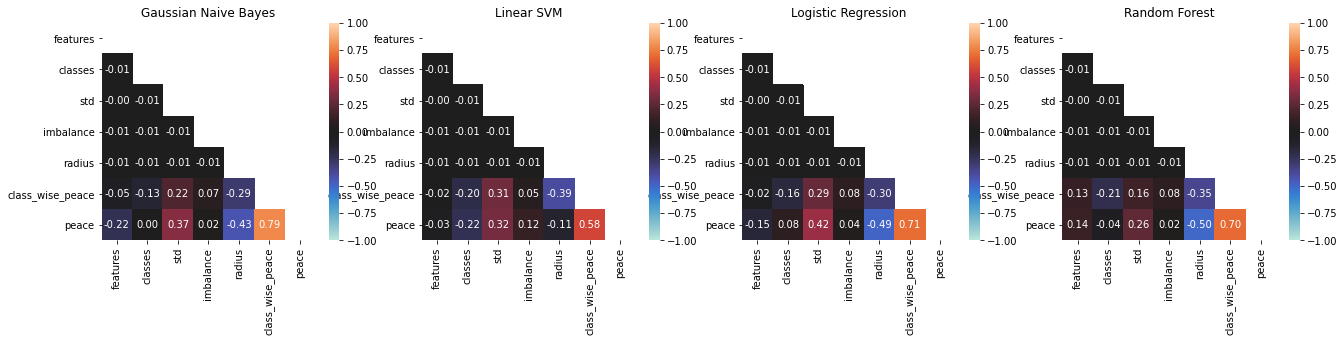

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(22,4))
for ax, (idx, df) in zip(axes, analysis[["features", "classes", "std", 'imbalance', "radius", "class_wise_peace", "peace", "clf"]].groupby("clf")):
    seaborn.heatmap(df.corr(), annot=True, ax=ax, center=0, vmin=-1, vmax=1, mask=mask, fmt=".2f")
    ax.set_title(idx)